# Lab 5 Analysis
Michael Chen
2021-07-23

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
from scipy import stats
import numpy as np
from pylr2 import regress2

## 1. Process extracted [Chl] fluorescence data

In [2]:
#Import data
chl = pd.read_csv('G2_HS_amber_fluor_extracted.csv')

In [3]:
#Calculate means and stdevs of the blanks (initial and acidified) at each gain setting
gainblanks_i={} #initial
for gain in chl[chl['Sample']=='blank']['I_Scale'].unique():
    gainblanks_i[gain]=chl[(chl['Sample']=='blank')&(chl['I_Scale']==gain)]['I_R_blank'].mean()

gainblanks_a={} #acidified
for gain in chl[chl['Sample']=='blank']['A_Scale'].unique():
    gainblanks_a[gain]=chl[(chl['Sample']=='blank')&(chl['A_Scale']==gain)]['A_R_blank'].mean()

### Compute the blank and scale corrected fluorescence readings

In [4]:
#Initial fluorescence (un-acidified)
def FCorrected_0(x):
    scaled_blank_i = gainblanks_i[x['I_Scale']]
    return (x['I_R_initial']-scaled_blank_i)/x['I_Scale']
    
chl['F0'] = chl.apply(lambda x: FCorrected_0(x),axis=1)

#Acidified fluorescence
def FCorrected_a(x):
    scaled_blank_a = gainblanks_a[x['A_Scale']]
    return (x['A_R_acid']-scaled_blank_a)/x['A_Scale']
    
chl['Fa'] = chl.apply(lambda x: FCorrected_a(x),axis=1)

### Calculate chlrophyll and pheophytin readings

In [5]:
#Turner calibration coefficients
M = 484.24
M_uncert = 5.97
A = 8.8
A_uncert = 0.41

V_acoh = 10 #Volume of acetone used (10 mL for all samples)

#Calculate chlrophyll and pheophytin readings
def chlorophyll(x):
    return M * (x['F0']-x['Fa']) * (V_acoh/x['volume_filtered'])

def pheophytin(x):
    return M * ((A * x['Fa'])-x['F0']) * (V_acoh/x['volume_filtered'])

chl['chlorophyll'] = chl.apply(lambda x: chlorophyll(x),axis=1)
chl['pheophytin'] = chl.apply(lambda x: pheophytin(x),axis=1)

### Compute Type A uncertainties (mean and stdev of triplicate dilutions)

In [6]:
def TypeA_uncert_mean_c(x):
    return chl[chl['Sample']==x['Sample']]['chlorophyll'].mean()
def TypeA_uncert_mean_p(x):
    return chl[chl['Sample']==x['Sample']]['pheophytin'].mean()
def TypeA_uncert_stdev_c(x):
    return chl[chl['Sample']==x['Sample']]['chlorophyll'].std()
def TypeA_uncert_stdev_p(x):
    return chl[chl['Sample']==x['Sample']]['pheophytin'].std()

chl['chlorophyll_mean'] = chl.apply(lambda x: TypeA_uncert_mean_c(x), axis=1)
chl['chlorophyll_stdev'] = chl.apply(lambda x: TypeA_uncert_stdev_c(x), axis=1)

chl['pheophytin_mean'] = chl.apply(lambda x: TypeA_uncert_mean_p(x), axis=1)
chl['pheophytin_stdev'] = chl.apply(lambda x: TypeA_uncert_stdev_p(x), axis=1)

### Compute Type B propogated uncertainties (partial differentials for each variable)

In [7]:
def typeB_M(x):
    return (x['F0'] - x['Fa'])*(V_acoh/x['volume_filtered'])
def typeB_F0(x):
    return M * (V_acoh/x['volume_filtered'])
def typeB_Fa(x):
    return -M * (V_acoh/x['volume_filtered'])
def typeB_Vfilt(x):
    return -M * (x['F0'] - x['Fa']) * (V_acoh/(x['volume_filtered']**2))
def typeB_Vacoh(x):
    return M * (x['F0'] - x['Fa']) * (1/x['volume_filtered'])

chl['typeB_M'] = chl.apply(lambda x: typeB_M(x),axis=1)
chl['typeB_F0'] = chl.apply(lambda x: typeB_F0(x),axis=1)
chl['typeB_Fa'] = chl.apply(lambda x: typeB_Fa(x),axis=1)
chl['typeB_Vfilt'] = chl.apply(lambda x: typeB_Vfilt(x),axis=1)
chl['typeB_Vacoh'] = chl.apply(lambda x: typeB_Vacoh(x),axis=1)

# Combine the propagated partial uncertainties into the total type B uncertainty
def typeB(x):
    return math.sqrt((x['typeB_M']**2 * M_uncert**2)
                     +(x['typeB_F0']**2 * x['I_uncert']**2)
                     +(x['typeB_Fa']**2 * x['A_uncert']**2)
                     +(x['typeB_Vfilt']**2 * x['Vfilt_uncert']**2)
                     +(x['typeB_Vacoh']**2 * 0.5**2)) #V_acoh uncertainty is +/- 0.5

chl['typeB_uncert'] = chl.apply(lambda x: typeB(x),axis=1)

In [8]:
# Aggregate triplicates (including their invidivual type B uncertainties)
chl_agg = chl.groupby('Dilution')['chlorophyll_mean','pheophytin_mean','typeB_uncert'].mean().reset_index()

### Plots

#### 1a. Linear-scale

<Figure size 432x288 with 0 Axes>

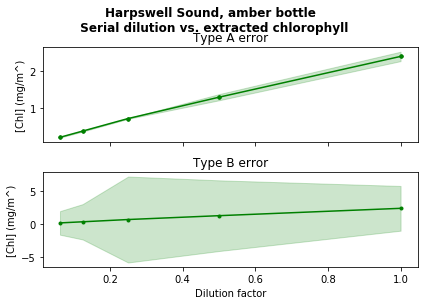

In [9]:
plt.clf()
fig, axs = plt.subplots(2, 1)

axs[0].plot(chl['Dilution'], chl['chlorophyll_mean'], 'g', label='chlorophyll (mg/m^3)',marker='.')
axs[0].fill_between(chl['Dilution'],chl['chlorophyll_mean'] - chl['chlorophyll_stdev'], chl['chlorophyll_mean'] + chl['chlorophyll_stdev'], color='g', alpha=0.2)
axs[0].set_title('Type A error')

axs[1].plot(chl_agg['Dilution'], chl_agg['chlorophyll_mean'], 'g', label='chlorophyll (mg/m^3)',marker='.')
axs[1].fill_between(chl_agg['Dilution'],chl_agg['chlorophyll_mean'] - chl_agg['typeB_uncert'], chl_agg['chlorophyll_mean'] + chl_agg['typeB_uncert'], color='g', alpha=0.2)
axs[1].set_title('Type B error')
#axs[1].set_ylim(0,2.5)


for ax in axs.flat:
    ax.set(xlabel='Dilution factor', ylabel='[Chl] (mg/m^)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.suptitle('Harpswell Sound, amber bottle \n Serial dilution vs. extracted chlorophyll',fontweight='bold',y=1.05)
plt.tight_layout()
plt.savefig('chl_typeA_typeB_linear.png',bbox_inches='tight')

#### 1b. Log scale

<Figure size 432x288 with 0 Axes>

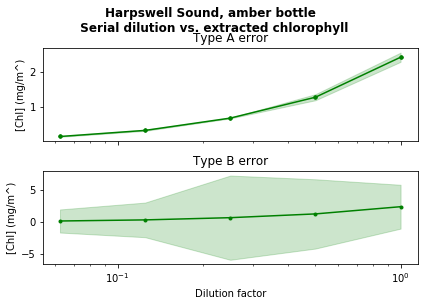

In [10]:
plt.clf()
fig, axs = plt.subplots(2, 1)

axs[0].plot(chl['Dilution'], chl['chlorophyll_mean'], 'g', label='chlorophyll (mg/m^3)',marker='.')
axs[0].fill_between(chl['Dilution'],chl['chlorophyll_mean'] - chl['chlorophyll_stdev'], chl['chlorophyll_mean'] + chl['chlorophyll_stdev'], color='g', alpha=0.2)
axs[0].set_title('Type A error')
axs[0].set_xscale('log')

axs[1].plot(chl_agg['Dilution'], chl_agg['chlorophyll_mean'], 'g', label='chlorophyll (mg/m^3)',marker='.')
axs[1].fill_between(chl_agg['Dilution'],chl_agg['chlorophyll_mean'] - chl_agg['typeB_uncert'], chl_agg['chlorophyll_mean'] + chl_agg['typeB_uncert'], color='g', alpha=0.2)
axs[1].set_title('Type B error')
#axs[1].set_ylim(0,2.5)
axs[1].set_xscale('log')


for ax in axs.flat:
    ax.set(xlabel='Dilution factor', ylabel='[Chl] (mg/m^)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

fig.suptitle('Harpswell Sound, amber bottle \n Serial dilution vs. extracted chlorophyll',fontweight='bold',y=1.05)
plt.tight_layout()
plt.savefig('chl_typeA_typeB_log.png',bbox_inches='tight')

#### 2. Both chlorophyll and pheophytin

<Figure size 432x288 with 0 Axes>

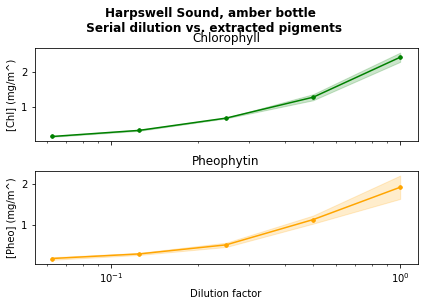

In [11]:
plt.clf()
fig, axs = plt.subplots(2, 1)

axs[0].plot(chl['Dilution'], chl['chlorophyll_mean'], 'g', label='chlorophyll (mg/m^3)',marker='.')
axs[0].fill_between(chl['Dilution'],chl['chlorophyll_mean'] - chl['chlorophyll_stdev'], chl['chlorophyll_mean'] + chl['chlorophyll_stdev'], color='g', alpha=0.2)
axs[0].set_title('Chlorophyll')
axs[0].set_xscale('log')
axs[0].set(xlabel='Dilution factor', ylabel='[Chl] (mg/m^)')

axs[1].plot(chl['Dilution'], chl['pheophytin_mean'], 'orange', label='pheophytin (mg/m^3)',marker='.')
axs[1].fill_between(chl['Dilution'],chl['pheophytin_mean'] - chl['pheophytin_stdev'], chl['pheophytin_mean'] + chl['pheophytin_stdev'], color='orange', alpha=0.2)
axs[1].set_title('Pheophytin')
axs[1].set_xscale('log')
axs[1].set(xlabel='Dilution factor', ylabel='[Pheo] (mg/m^)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
     
fig.suptitle('Harpswell Sound, amber bottle \n Serial dilution vs. extracted pigments',fontweight='bold',y=1.05)
plt.tight_layout()
plt.savefig('pigments_extracted.png')

## 2. In vivo data / fluorometer calibration

In [12]:
fl = pd.read_csv('G2_fluorometer_invivo.csv')

In [13]:
# Aggregate measurements for each dilution sample
fl_agg = fl.groupby(['sample']).agg({'dilution':'first','wavelength1':'first','wavelength1_count':['mean','std']}).reset_index()
fl_agg.columns = ['sample','dilution','wavelength','wavelength_count_mean','wavelength_count_stdev']

### Compare Fchl vs [Chl]

In [14]:
# Remake the aggregation dataframe
chl_agg = chl.groupby(['Sample']).agg({'Dilution':'first','chlorophyll_mean':'first','chlorophyll_stdev':'first'}).reset_index()

In [15]:
# Combine the in vivo FCl and in vivo extracted [Chl] data for plotting and regression. 
# Not the cleanest way of doing it? But I checked the output table and it looked correct

CvsF = pd.concat([fl_agg,chl_agg],axis=1)

#For the extracted [Chl] data, artifically set the [Chl] mean and std values to 0 (these weren't actually calculated). 
#This is an assumption for the calibration to set an intercept
CvsF.iloc[5,7] = 0
CvsF.iloc[5,8] = 0

# Throw out the dark measurement for now. It won't be used for correlation. Not sure if this is appropriate?
CvsF = CvsF.iloc[0:6,]

<ErrorbarContainer object of 3 artists>

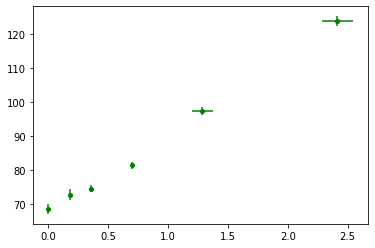

In [16]:
plt.errorbar(CvsF['chlorophyll_mean'],CvsF['wavelength_count_mean'],
             xerr=CvsF['chlorophyll_stdev'],
             yerr=CvsF['wavelength_count_stdev'],
             color='green',
            marker='.',
            linestyle='None',
            markersize=8)

### Type 2 linear regression

In [17]:
# Use a type 2 linear model, to account for uncertainty in both Fcl and [Chl] measurements. 

# In Nils's code, I selected the "geometric mean" model for Type 2
# Reasoning from https://www.mbari.org/regression-rules-of-thumb/

# "For comparing two different measured parameters (like DOC vs TCO2, AOU, etc.) and especially when the parameters have different units or widely varying metrics, then the reduced major axis is the method of choice."
# "The reduced major axis method is both difficult and tedious to compute, so I recommend that the geometric mean regression [lsqfitgm] be used in this case as this gives the identical line (see Ricker, 1973, for the derivation)."
# Required an intercept

regress2(_x = CvsF['chlorophyll_mean'], 
         _y = CvsF['wavelength_count_mean'], 
         _method_type_2 = 'geometric mean', 
         _need_intercept = True,
        _weight_x = CvsF['chlorophyll_stdev'],
        _weight_y = CvsF['wavelength_count_stdev'])


/Users/Michael/miniconda3/envs/michael/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



{'slope': 23.21591003257317,
 'intercept': 67.3787388777046,
 'r': 0.997953182692691,
 'std_slope': 0.742694580008587,
 'std_intercept': 0.8641170621904055,
 'predict': 0    123.404104
 1     97.245178
 2     83.586060
 3     75.550587
 4     71.551429
 5     67.378739
 Name: chlorophyll_mean, dtype: float64}

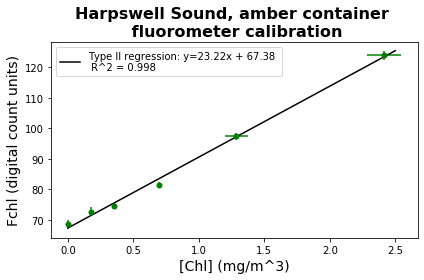

In [18]:
plt.clf()
# Plot the correlation with the Type II regression
fig = plt.errorbar(CvsF['chlorophyll_mean'],CvsF['wavelength_count_mean'],
             xerr=CvsF['chlorophyll_stdev'],
             yerr=CvsF['wavelength_count_stdev'],
             color='green',
            marker='.',
            linestyle='None',
            markersize=10)

#Make mockup regression data to plot
regress_x = np.linspace(0,2.5,100) #100 points between 0 and 2.5
regress_y = 23.22*regress_x+67.38

fig = plt.plot(regress_x, regress_y, c='black', label='Type II regression: y=23.22x + 67.38 \n R^2 = 0.998')

plt.title('Harpswell Sound, amber container \n fluorometer calibration',fontweight='bold',fontsize=16)
plt.legend()
plt.ylabel('Fchl (digital count units)',fontsize=14)
plt.xlabel('[Chl] (mg/m^3)',fontsize=14)

plt.tight_layout()
plt.savefig('harpswell_sound_fluorometer_calibration.png',bbox_inches='tight')